In [1]:
# Set Up
import os
import torch
from torch import nn

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision

import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /gdrive
/gdrive


In [2]:
# Data Loader
class DataLoader():
  def __init__(self, dir="MyDrive/data", width=300, height=432):
    self.width = width
    self.height = height
    self.root = dir

  def load(self, dataset="/test", batchSize=10, shuffle=True, workers=2):
    transform = transforms.Compose([transforms.Resize((124, 124)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    dataset = datasets.ImageFolder(root=self.root + dataset, transform=transform)
    dataset = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=shuffle, num_workers=workers)
    return dataset


In [3]:
# Multilayer Perceptron
class MLP(nn.Module):
  def __init__(self, inputSize=124*124*3, outputSize=8, lr=0.01):
    super().__init__()

    self.net = nn.Sequential(
      nn.Flatten(),
      nn.Linear(inputSize, 1024),
      nn.ReLU(),
      nn.Linear(1024, 512),
      nn.ReLU(),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Linear(256, outputSize),
      nn.ReLU(),
    )

    self.lr = lr

  def forward(self, X):
    return self.net(X)

  def loss(self, y_hat, y):
    # print(y, y_hat)
    fn = nn.CrossEntropyLoss()
    return fn(y_hat, y)

  def configureOptimiser(self):
    return torch.optim.Adam(self.parameters(), self.lr)

In [4]:
# Trainer Class
class Trainer():
  def __init__(self, nEpochs=3):
    self.maxEpochs = nEpochs

  def expLR(self, lr):
    return lr * 0.95

  # The fitting step
  def fit(self, model, data):

    self.data = data

    # configure the optimizer
    self.optimiser = model.configureOptimiser()
    self.model = model

    for epoch in range(self.maxEpochs):
      print("Epoch: ", epoch + 1)
      self.fitEpoch()
      self.model.lr = self.expLR(self.model.lr)

    print("Training process has finished")

  def fitEpoch(self):
    currentLoss = 0.0

    for i, data in enumerate(self.data):
      # Get input aand its corresponding groundtruth output
      inputs, target = data

      self.optimiser.zero_grad()

      # get output from the model, given the inputs
      outputs = self.model(inputs)

      # get loss for the predicted output
      loss = self.model.loss(outputs, target)

      # get gradients w.r.t the parameters of the model
      loss.backward()

      # update the parameters (perform optimization)
      self.optimiser.step()

      currentLoss += loss.item()
      if i % 10 == 9:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, currentLoss / 10))
          currentLoss = 0.0

  def evaluate(self, model, data):
    allCorrect = 0
    for images, labels in data:
      outputs = model(images)
      estLabel = torch.max(outputs, 1).indices
      correct = sum(estLabel == labels)
      allCorrect += correct
    print("Correct: ", allCorrect, "Total: ", len(data) * data.batch_size)

In [7]:
# Train Model
trainSet = DataLoader().load(dataset="/train", batchSize=34, shuffle=True, workers=2)
model = MLP(lr=1e-04)
trainer = Trainer(nEpochs=10)
trainer.fit(model, trainSet)
trainer.evaluate(model=model, data=trainSet)

Epoch:  1
Loss after mini-batch    10: 1.534
Loss after mini-batch    20: 1.110
Loss after mini-batch    30: 1.057
Loss after mini-batch    40: 0.873
Loss after mini-batch    50: 0.855
Loss after mini-batch    60: 0.850
Loss after mini-batch    70: 0.832
Loss after mini-batch    80: 0.859
Loss after mini-batch    90: 0.741
Loss after mini-batch   100: 0.734
Epoch:  2
Loss after mini-batch    10: 0.646
Loss after mini-batch    20: 0.604
Loss after mini-batch    30: 0.628
Loss after mini-batch    40: 0.574
Loss after mini-batch    50: 0.607
Loss after mini-batch    60: 0.552
Loss after mini-batch    70: 0.594
Loss after mini-batch    80: 0.625
Loss after mini-batch    90: 0.477
Loss after mini-batch   100: 0.496
Epoch:  3
Loss after mini-batch    10: 0.430
Loss after mini-batch    20: 0.507
Loss after mini-batch    30: 0.472
Loss after mini-batch    40: 0.426
Loss after mini-batch    50: 0.479
Loss after mini-batch    60: 0.491
Loss after mini-batch    70: 0.499
Loss after mini-batch    

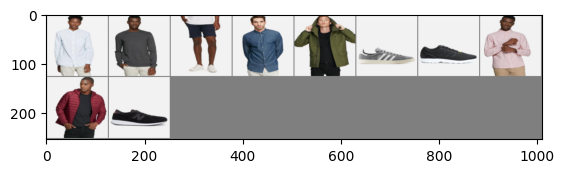

GroundTruth:  shirts knitwear shorts shirts jackets shoes shoes shirts jackets shoes
Estimated Labels:  shirts tees  shorts shirts tees  shoes shoes tees  shirts shoes
Correct:  tensor(333) Total:  390


In [8]:
# Evaluate Model
def imgShow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

validloader = DataLoader().load(dataset="/valid", batchSize=10, shuffle=True, workers=2)
classes = validloader.dataset.classes

dataiter = iter(validloader)
images, labels = next(dataiter)

imgShow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(images.shape[0])))

output = model(images)
estimatedLabels = torch.max(output, 1).indices

print('Estimated Labels: ', ' '.join(f'{classes[estimatedLabels[j]]:5s}' for j in range(images.shape[0])))

trainer.evaluate(model=model, data=validloader)